#### AirBNB Seattle dataset

First read in the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# import AllTogether as t
import seaborn as sns
%matplotlib inline

#### Listings.csv

Take a look at the data set describing all the different appartments that are being offered at airBNB in seattle.

In [2]:
df_listing = pd.read_csv('listings.csv')
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### Reviews.csv

Take a look at the data set describing the different reviews.

In [3]:
df_reviews = pd.read_csv('reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


#### Calendar.csv

Take a look at the data set describing the different bookings for an appartment. At first glance it might be possible to take a look when seattle is most attractive to tourist.

In [4]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


#### Data preperation

Create a dataframe that contains the information about how often an appartment is booked. Later on it turned out that the column that I calculated here already existed in the listings.csv file:)

In [16]:
# First do some group by and pivotting to get the information we need.
df_occupied = pd.DataFrame(pd.pivot_table(df_calendar.groupby(['listing_id', 'available']).count()['date'].reset_index(),index=["listing_id"], columns='available', values='date').reset_index(), columns=['listing_id', 'f', 't']).fillna(0)
# Then rename our columns, available(f) means that the house was occupied, available(t) means that the house was available
df_occupied.columns = ['listing_id', 'occupied', 'available']

# Create a column percentage that shows how often an appartment is occupied. This will be our main value that we want to demistify
df_occupied['percentage'] = df_occupied['occupied'] / (df_occupied['available'] + df_occupied['occupied'])

# First I made sure that all apartments contained 365 rows in the calendar.csv and then concluded that we don't need the available and occupied column.
# So we can remove the other unnecessary columns
df_occupied.drop(['available', 'occupied'], axis=1, inplace=True)

#### Merge the data of calendar.csv and listing.csv

Now we want to create a dataframe that contains data about the appartments and their occupation.

In [17]:
# Join two dataframes on listing_id
data = df_listing.merge(df_occupied, left_on='id', right_on='listing_id', how='inner')

In [18]:
# The ID's in this dataframe were only usefull for making joins between the datasets, but not for any sort of prediction.
# Therefore we drop the ID columns.
data.drop(['id', 'scrape_id', 'host_id','listing_id', 'latitude', 'longitude', 'license'], axis=1, inplace=True)

#### Investigate missing data

Make sure we remove columns that don't have any additional value, like columns that have a lot of data missing.

In [8]:
list(data.columns[data.isnull().mean()>=0.90])

['square_feet']

In [9]:
data.drop(['square_feet'], axis=1, inplace=True)

Make sure that we remove columns that only contain a single value.

In [10]:
# Get overview of how many unique values a column has.
s = data.nunique()
unique_data = pd.DataFrame({'column':s.index, 'unique_values':s.values})

In [27]:
unique_data

,column,unique_values
0,listing_url,3818
1,last_scraped,1
2,name,3792
3,summary,3478
4,space,3119
5,description,3742
6,experiences_offered,1
7,neighborhood_overview,2506
8,notes,1999
9,transit,2574


In [29]:
# Drop all columns that have a single value
for idx, row in unique_data.iterrows():
    if row.unique_values == 1:
        data.drop([row.column], axis=1, inplace=True)

#### Clean pricing information

Prep the data column that contain pricing information, remove preceding $ and thousand seperator ','.

In [12]:
# The pricing column contains all prices in dollars, but these are stored as an object. First we need to remove the $
cols_to_check = ['price', 'weekly_price', 'monthly_price']
for col in cols_to_check:
    data[col] = data[col].apply(lambda x : x[1:].replace(",", "") if str(x).startswith("$") else x)
# Then we need to cast these columns to float.
data[cols_to_check] = data[cols_to_check].astype(float)

Then we want to make sure there are no missing values in columns weekly_price and monthly_price. This can be done by using the day price to calculate the monthly price and the weekly price. It was decided to muliply the day_price with 7 to calculate the week_price, and multiply the week_price with [4.34524](https://www.google.nl/search?q=how+many+weeks+does+an+average+month+have&rlz=1C1CHBD_enNL817NL817&oq=how+many+weeks+does+an+average+month+have&aqs=chrome..69i57.5535j0j4&sourceid=chrome&ie=UTF-8) to get the month_price.

In [13]:
# First make sure we have a weekly_price in all columns
data['weekly_price'] = data.apply(
    lambda row: row['price']*7 if np.isnan(row['weekly_price']) else row['weekly_price'],
    axis=1
)

# Next, we make sure that we a monthly_price in all cases
data['monthly_price'] = data.apply(
    lambda row: row['weekly_price']*4.34524 if np.isnan(row['monthly_price']) else row['monthly_price'],
    axis=1
)

#### Correlation heatmap

An interesting thing to look at might be the correlation heatmap. After looking at the heatmap it turned out that the column that I calculated in the steps above are exactly the same as column availability_365, therefore we have to remove this column from further analysis. From the heatmap it also turns out that columns host_listings_count and  host_total_listings_count correlates perfect. Therefore one of these columns has to be removed from the analysis.

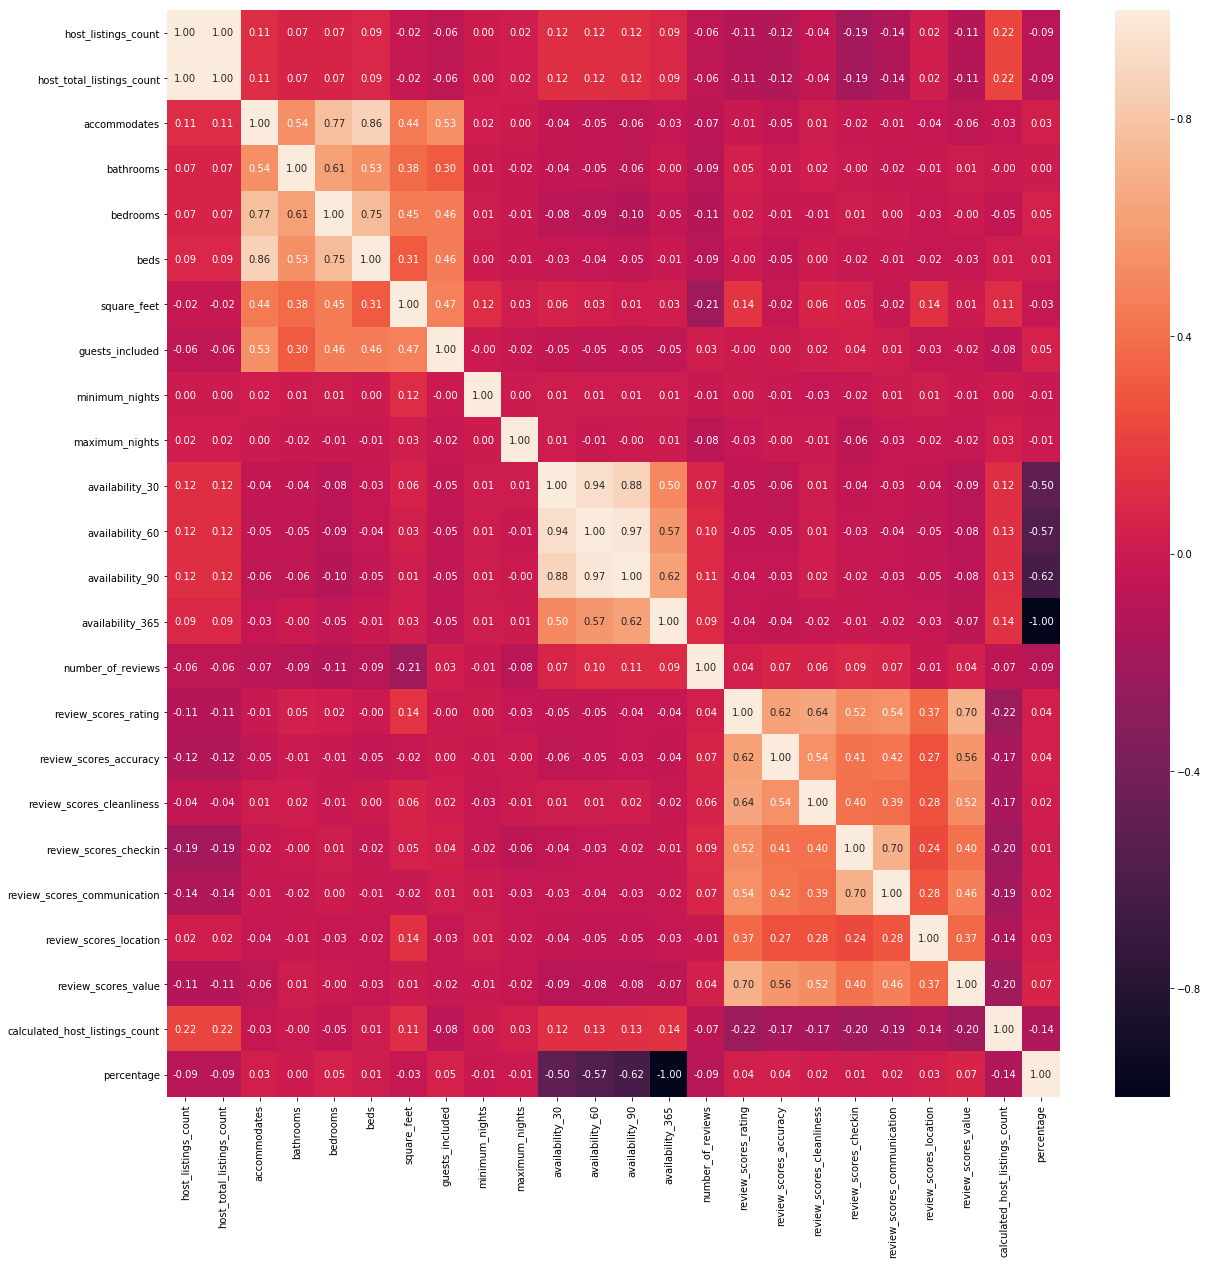

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".2f");

Take a look at how we should interpret the variable availibility_365.

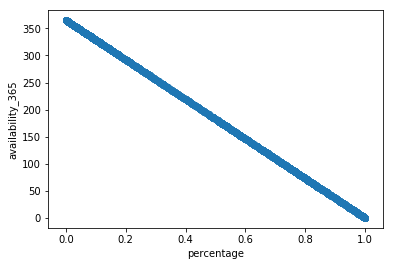

In [20]:
plt.scatter(x=data['percentage'], y=data['availability_365']);
plt.xlabel('percentage');
plt.ylabel('availability_365');

This means that the lower the value in availability_365, the higher the occupancy rate is for that given house. So a low value for availability_365 is good. For now we can drop this variable percentage. It also turned out from the heatmap that the column host_total_listings_count correlates perfect with host_listings_count, therefore we have to drop one of these variables as well. Then we can create the heatmap again.

In [21]:
# Drop columns as discussed.
data.drop(['percentage', 'host_total_listings_count'], axis=1, inplace=True)

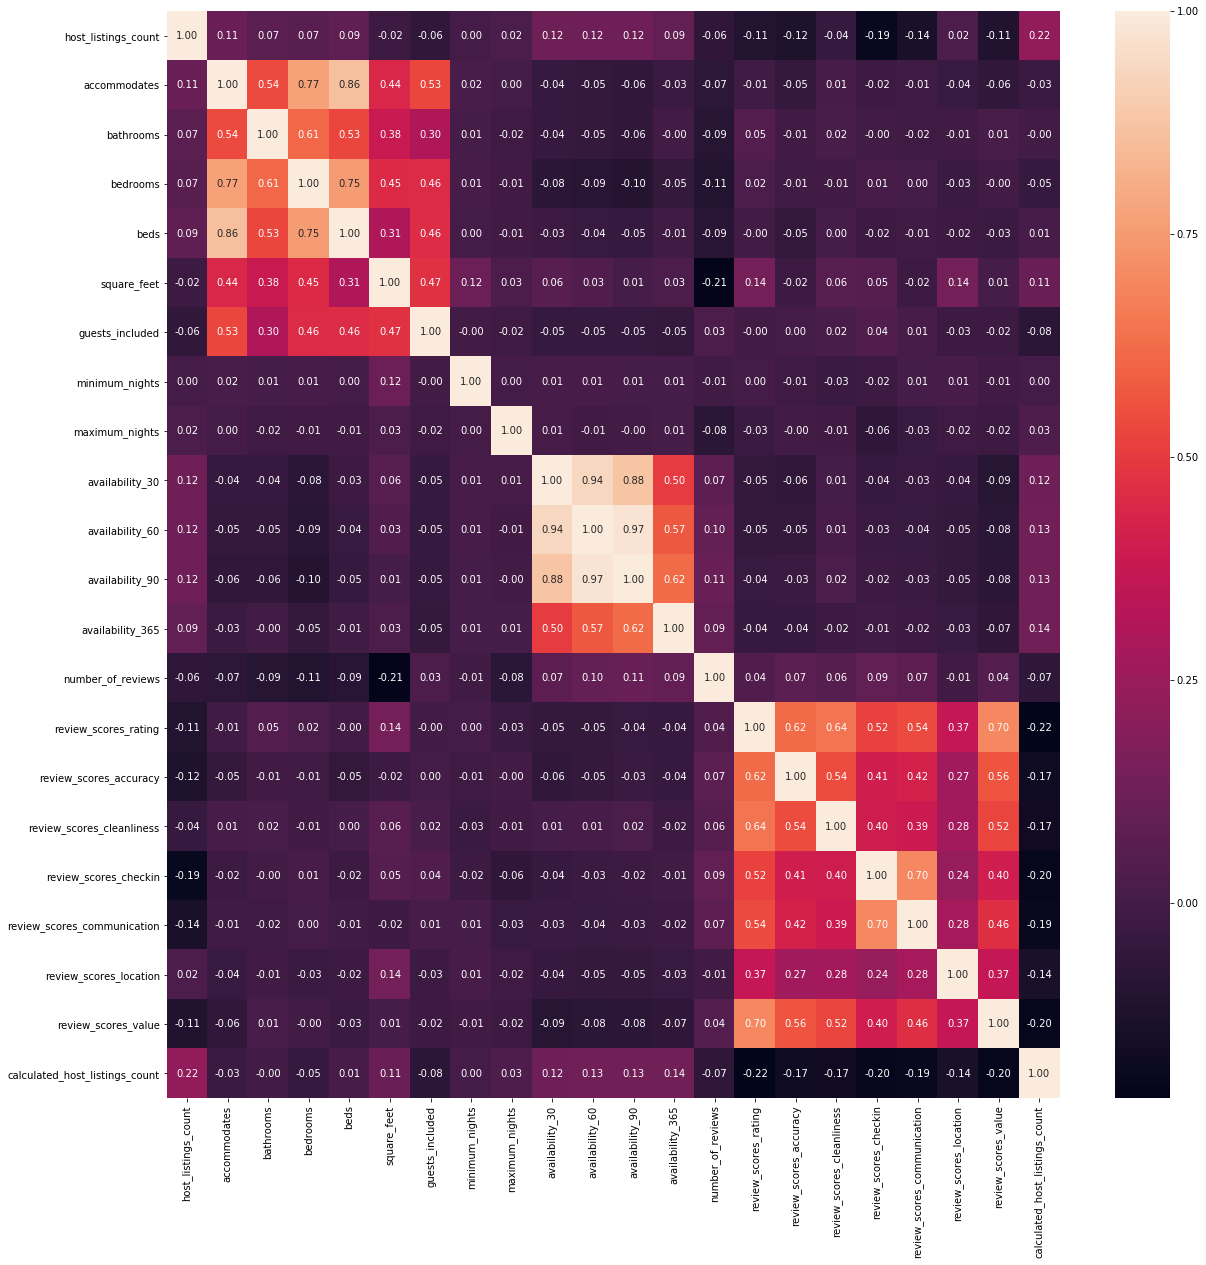

In [22]:
# Create the heatmap again.
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), ax=ax, annot=True, fmt=".2f");

In [31]:
data.shape

(3818, 76)

In [229]:
sf = data.isnull().mean()
missing_data = pd.DataFrame({'column':sf.index, 'percentage':sf.values})

In [244]:
data.groupby(['cancellation_policy']).mean()[['availability_30', 'availability_60', 'availability_90', 'availability_365']].reset_index()

,cancellation_policy,availability_30,availability_60,availability_90,availability_365
0,flexible,15.947826,34.751304,54.566957,239.411304
1,moderate,16.401279,36.179057,57.338929,239.660272
2,strict,17.806634,39.050812,61.592096,253.637262


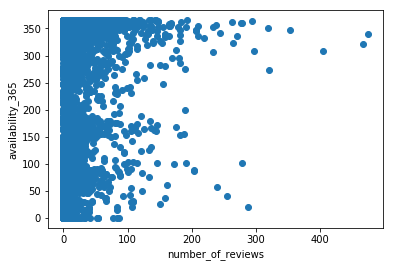

In [267]:
# nr_of_reviews = data.groupby(['number_of_reviews']).mean()[['availability_365']].reset_index()
plt.scatter(x=data['number_of_reviews'], y=data['availability_365']);
plt.xlabel('price');
plt.ylabel('availability_365');

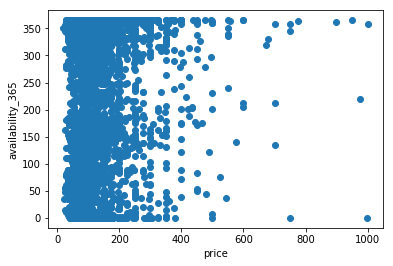

In [259]:
plt.scatter(x=data['price'], y=data['availability_365']);
plt.xlabel('price');
plt.ylabel('availability_365');

In [254]:
# plt.scatter(x=data['room_type'], y=data['availability_365'])
data.groupby(['room_type']).mean()[['availability_30', 'availability_60', 'availability_90', 'availability_365']].reset_index()

,room_type,availability_30,availability_60,availability_90,availability_365
0,Entire home/apt,15.499410,34.179850,54.130264,233.457300
1,Private room,19.117241,41.562931,65.291379,264.280172
2,Shared room,21.623932,46.965812,72.444444,297.111111


In [266]:
data.groupby(['neighbourhood_cleansed']).mean()[['availability_365']].reset_index().sort_values(by='availability_365', ascending=True)

,neighbourhood_cleansed,availability_365
71,South Lake Union,165.444444
69,South Beacon Hill,183.250000
51,North Beach/Blue Ridge,187.571429
67,Seaview,190.916667
64,Riverview,198.625000
48,Montlake,205.578947
41,Madrona,206.276596
38,Lower Queen Anne,207.127660
23,Genesee,210.205882
20,First Hill,215.740741


In [277]:
data.groupby(['experiences_offered']).mean()[['availability_30', 'availability_60', 'availability_90', 'availability_365']].reset_index()

,experiences_offered,availability_30,availability_60,availability_90,availability_365
0,none,16.786276,36.814825,58.082504,244.772656


In [273]:
data.groupby(['require_guest_profile_picture']).mean()[['availability_30', 'availability_60', 'availability_90', 'availability_365']].reset_index()

,require_guest_profile_picture,availability_30,availability_60,availability_90,availability_365
0,f,16.526165,36.314841,57.396340,244.169574
1,t,19.619938,42.261682,65.557632,251.342679


In [276]:
missing_data[missing_data['percentage'] == 0]

,column,percentage
0,listing_url,0.0
1,last_scraped,0.0
2,name,0.0
5,description,0.0
6,experiences_offered,0.0
12,picture_url,0.0
14,host_url,0.0
27,host_verifications,0.0
30,street,0.0
32,neighbourhood_cleansed,0.0
